In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from keras.models import load_model

best_model = load_model('../models/daily.h5')

Using Theano backend.


In [3]:
from pickle import load

scaler = load(open('../models/scaler.pkl', 'rb'))

In [4]:
import json
COLUMNS = []

with open('../models/columns.json') as column_file:
    COLUMNS = json.load(column_file)

In [5]:
backtest_stocks = pd.read_hdf('../data/clean/computed_stocks.h5', key='stocks_2011')
backtest_stocks.index = pd.to_datetime(backtest_stocks.index)
backtest_stocks = backtest_stocks['2011']

In [6]:
import json

symbols = []
with open('../files/public/top_symbols_100.json') as top_symbols:
    symbols = json.load(top_symbols)

In [7]:
def backtest(forecasts, predictions, buy):
    baseline = 100
    model = 100
    position = 100
    trade = 100
    ideal = 100
    ideal_trade = 100
    buy_signal = False
    for date, prediction in zip(forecasts.index, predictions):
        if prediction > buy:
            if buy_signal == False:
                trade = 100
                position = trade
                model -= position
                buy_signal = True
        elif prediction <= buy:
            if buy_signal == True:
                model += position
                buy_signal = False
        if buy_signal == True:
            position += position * forecasts[date]
        baseline += baseline * forecasts[date]
        
    if buy_signal == True:
        model += position
    return baseline, model

In [8]:
from tqdm.notebook import tqdm

def calculate_profit(symbol, buy):
    X = backtest_stocks[backtest_stocks.symbol == symbol][COLUMNS]
    if X.shape[0] == 0:
        return 100, 100
    X_scaled = scaler.transform(X)
    predictions = best_model.predict(X_scaled)[:, 1]
    forecasts = backtest_stocks[backtest_stocks.symbol == symbol].forecast
    
    return backtest(forecasts, predictions, buy)

baselines = []
models = []

num_symbols = len(symbols)

for symbol in tqdm(symbols[:num_symbols]):
    baseline, model = calculate_profit(symbol, .5)
    print(symbol, baseline, model)
    if baseline == 0:
        num_symbols -= 1
    baselines.append(baseline)
    models.append(model)

num_symbols * 100, sum(baselines), sum(models)

FTAI 100 100
AAPL 122.88738227835194 114.10348224935487
MSFT 92.78055754110076 105.59778378257695
CSCO 88.23816495851631 104.60541264557563
INTC 116.30695443645072 125.02453471915913
ORCL 81.11954459203038 104.87825967495579
EBAY 105.75313807531383 130.41283638671734
BAC 39.18252290345313 81.67688347877403
NIO 114.74098683401013 101.43071992015426
FB 100 100
SIRI 23.05636140213084 43.57508428526694
PAE 100 100
SNAP 100 100
UBER 100 100
GE 97.97592997811824 119.39852499624276
TWTR 100 100
VALE 61.05892399658416 101.22654335155627
VXX 97.36914223074822 141.50500427601526
F 62.37681159420287 74.35353344741787
KTB 100 100
AMAT 76.1735419630157 122.69657221853191
QCOM 109.00757273814277 117.58192035383992
NFLX 38.83768651592376 79.77259016490608
NOK 45.215759849906206 80.3875569296502
PFE 122.39819004524884 119.39085719824644
BABA 100 100
V 143.97334089619972 130.67196811050997
ZNGA 100 100
ITUB 75.66318993688171 87.74986891627152
BB 100 100
PBR 66.63984982569058 119.35946736453717
NVDA 87.

(10000, 9343.361020773586, 10372.525537010237)

In [21]:
google = backtest_stocks[backtest_stocks.symbol == 'F'].copy()

In [22]:
X = google[COLUMNS]
X_scaled = scaler.transform(X)
predictions = best_model.predict(X_scaled)[:, 1]

google['prediction'] = predictions

In [23]:
google_up_correct = google[(google.prediction >= 0.5) & (google.forecast >= 0)]
google_up_incorrect = google[(google.prediction >= 0.5) & (google.forecast < 0)]
google_down_correct = google[(google.prediction < 0.5) & (google.forecast < 0)]
google_down_incorrect = google[(google.prediction < 0.5) & (google.forecast >= 0)]

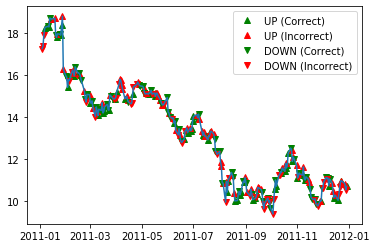

In [24]:
_ = plt.plot(google_up_correct.close, marker='^', linestyle='None', c='g', label='UP (Correct)')
_ = plt.plot(google_up_incorrect.close, marker='^', linestyle='None', c='r', label='UP (Incorrect)')
_ = plt.plot(google_down_correct.close, marker='v', linestyle='None', c='g', label='DOWN (Correct)')
_ = plt.plot(google_down_incorrect.close, marker='v', linestyle='None', c='r', label='DOWN (Incorrect)')
_ = plt.plot(google.close)
_ = plt.legend()

In [25]:
backtest(google.forecast, google.prediction, 0.5)

(62.37681159420287, 74.35353344741787)

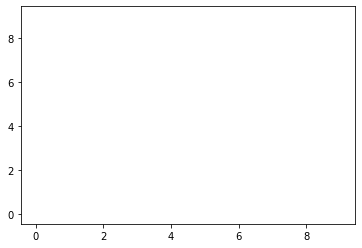

In [14]:
from matplotlib import pyplot as plt
from celluloid import Camera

fig = plt.figure()
camera = Camera(fig)
for i in range(10):
    plt.plot([i] * 10)
    camera.snap()
animation = camera.animate()
animation.save('celluloid_minimal.gif', writer='pillow')

In [17]:
def backtest_animation(forecasts, predictions, buy_signals, trade=100):
    baseline = trade
    baseline_profits = []
    
    models = [trade] * len(buy_signals)
    positions = [trade] * len(buy_signals)
    signals = [False] * len(buy_signals)
    
    fig = plt.figure()
    camera = Camera(fig)
    plt.title('Profits of model at various buy signals.')
    plt.xlabel('Date')
    plt.ylabel('Profit (USD)')
    colors = ['r', 'g', 'b']
    
    dates = []
    profits = [[] for i in range(len(buy_signals))]
    
    for date, prediction in zip(forecasts.index, predictions):
        dates.append(date)
        for i, signal in enumerate(signals):
            if prediction >= buy_signals[i]:
                if signals[i] == False:
                    positions[i] = trade
                    signals[i] = True
            elif prediction < buy_signals[i]:
                if signals[i] == True:
                    models[i] += positions[i] - trade
                    signals[i] = False
            if signals[i] == True:
                positions[i] += positions[i] * forecasts[date]
            profit = (models[i] - trade) + (positions[i] - trade)
            profits[i].append(profit)
            plt.plot(dates, profits[i], c=colors[i], label=f'Signal {buy_signals[i]}')
        baseline += baseline * forecasts[date]
        baseline_profits.append(baseline - trade)
        plt.plot(dates, baseline_profits, c='purple', label='baseline')
        camera.snap()
    
    for i, signal in enumerate(signals):
        if signal == True:
            models[i] += positions[i] - trade
    
    animation = camera.animate()
    animation.save('backtest.gif', writer = 'pillow', fps=20)

    return baseline, models

(62.37681159420287, [70.37964334135955, 74.35353344741787, 80.18060066227548])

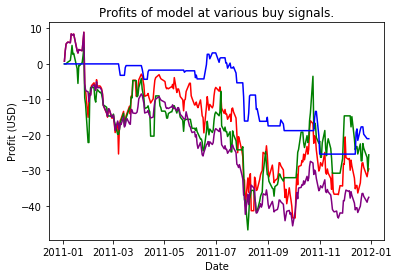

In [26]:
backtest_animation(google.forecast, google.prediction, [0.25, 0.5, 0.75])